### Tolmachev Anton a.tolmachyov@innopolis.university

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, mean_squared_error, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("a1_dataset.csv")
target = df.pop('target')

In [3]:
df.head()

,var1,var2,var3,var4,var5,var6,var7
0,509.18,417.681,Micronesia,138.0,393.00,no,2019-07-20 13:21:37
1,446.06,666.182,Dominica,81.0,352.05,yes,2019-04-04 21:30:46
2,235.50,398.097,Isle of Man,90.0,339.00,no,2019-03-03 02:59:37
3,306.02,518.163,Turkmenistan,102.0,439.25,yes,2019-03-19 08:00:58
4,453.08,600.156,Cameroon,105.0,422.95,no,2019-03-18 13:22:35


In [4]:
df.describe()

,var1,var2,var4,var5
count,925.000000,925.000000,325.000000,925.000000
mean,360.116562,548.390134,108.452308,325.393946
std,87.866662,135.221460,26.325744,78.862779
min,209.560000,139.965000,57.000000,163.000000
25%,278.640000,467.373000,87.000000,257.900000
50%,367.640000,569.841000,105.000000,342.350000
75%,437.600000,652.278000,126.000000,393.000000
max,539.920000,794.848000,180.000000,457.150000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925 entries, 0 to 924
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   var1    925 non-null    float64
 1   var2    925 non-null    float64
 2   var3    925 non-null    object 
 3   var4    325 non-null    float64
 4   var5    925 non-null    float64
 5   var6    925 non-null    object 
 6   var7    925 non-null    object 
dtypes: float64(4), object(3)
memory usage: 50.7+ KB


# Encoding:

In [6]:
def encode(df, col_names):
    df_encoded = df.copy()
    encoder = OneHotEncoder(sparse=False, drop='first')

    new_feats = encoder.fit_transform(df[col_names])

    new_cols = pd.DataFrame(new_feats, dtype=int, columns=encoder.get_feature_names(col_names))
    df_encoded = pd.concat([df_encoded, new_cols], axis=1)
    df_encoded.drop(col_names, axis=1, inplace=True)
    return df_encoded

# Imputation:

In [7]:
cat_cols = ['var3', 'var6', 'var7']
num_cols = ['var1', 'var2', 'var4', 'var5']

x_cat = df[cat_cols]
x_cat = encode(x_cat, cat_cols)
x_num = df[num_cols]

df_not_sparse = pd.concat([x_cat, x_num], axis=1)
df_not_sparse.dropna(subset=['var4'], inplace=True)

x_num = df_not_sparse[num_cols]
y = x_num.pop('var4')
x_cat = df_not_sparse.drop(columns=num_cols)


In [8]:
degrees = list(range(2, 11))
degrees.append(1) # the degree of 1 stands for linear regression
scores=[]

for degree in degrees:
    polynomial_features = PolynomialFeatures(degree=degree)

    x_num_poly = polynomial_features.fit_transform(x_num)

    x = pd.concat([x_cat, pd.DataFrame(x_num_poly)], axis=1)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    polynomial_features = LinearRegression()
    polynomial_features.fit(x_train, y_train)

    y_pred = pd.Series(polynomial_features.predict(x_test))
    score = mean_squared_error(y_test, y_pred)

    scores.append(score)


In [9]:
best_score_degree = degrees[np.argmin(scores)]
print('The Best score belongs to the polynomial regression with degree of {}'.format(best_score_degree))

The Best score belongs to the polynomial regression with degree of 3


In [10]:
polynomial_features = PolynomialFeatures(degree=best_score_degree)

x_cat_all = df[cat_cols]
x_cat_all = encode(x_cat_all, cat_cols)
x_num_all = df[num_cols]
y = x_num_all.pop('var4')
y_dropna = y.dropna()

x_all = pd.concat([x_cat_all, pd.DataFrame(polynomial_features.fit_transform(x_num_all)), y], axis=1)


polynomial_features = LinearRegression()
polynomial_features.fit(x_all.dropna().drop(columns='var4'), y_dropna)

y_pred = polynomial_features.predict(x_all.drop(columns='var4'))
y_pred = pd.DataFrame(y_pred, columns=['var4'])

x_all.fillna(y_pred, inplace=True)

# Implementing the PCA technique:

In [11]:
from numpy.linalg import eig

class PCA:

    def __init__(self, d):
        self.d = d
        self.eig = None
        self.mean = None

    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        X -= self.mean
        C = np.cov(X.T)
        w, v = eig(C)
        v = v.T
        idx = np.argsort(w)[::-1]
        w = w[idx]
        v = v[idx]
        self.eig = v[0:self.d]

    def transform(self, X, if_abs=True):
        X -= self.mean
        if if_abs:
            return np.dot(X, self.eig.T).__abs__()
        else:
            return np.dot(X, self.eig.T)

    def fit_transform(self, X, if_abs=True):
        self.fit(X)
        return self.transform(X, if_abs)

def show_PCA(X, Y):
    pca = PCA(2)
    X_proj = pca.fit_transform(X, False)
    x1 = X_proj[:, 0]
    x2 = X_proj[:, 1]
    plt.scatter(x1, x2, c=Y, edgecolors='none', alpha=0.8, cmap=plt.cm.get_cmap('viridis', 3))
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.colorbar()
    plt.show()

    pca = PCA(1)
    X_proj = pca.fit_transform(X, False)
    x1 = X_proj[:, 0]
    plt.scatter(x=x1, y=Y, edgecolors='none', alpha=0.8, cmap=plt.cm.get_cmap('viridis', 3))
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.colorbar()
    plt.show()

ValueError: 'c' argument has 925 elements, which is inconsistent with 'x' and 'y' with size 1850.

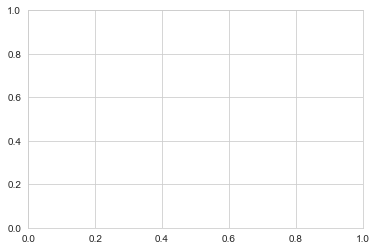

In [12]:
show_PCA(x_all.drop(columns=['var4']), x_all['var4'])

# Training:

In [844]:
data = x_all

In [845]:
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

#### Logistic Regression:

In [846]:
log_reg_model = LogisticRegression()

In [847]:
param_grid = [{
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['newton-cg', 'sag', 'saga', 'lbfgs', 'liblinear'],
    'max_iter': [100, 1000, 1500],
    'random_state': [42]
}]
clf_log_reg = GridSearchCV(estimator=log_reg_model, param_grid=param_grid, cv=3, scoring='f1')

In [848]:
best_clf_log_reg = clf_log_reg.fit(x_train, y_train)

In [849]:
best_clf_log_reg.best_estimator_

LogisticRegression(max_iter=1000, random_state=42, solver='newton-cg')

LogisticRegression(max_iter=1000, random_state=42, solver='newton-cg')

In [850]:
print(best_clf_log_reg.best_score_)

y_pred = best_clf_log_reg.predict(x_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1:', f1_score(y_test, y_pred))

0.9576999524089471
Accuracy: 0.972972972972973
F1: 0.9714285714285714
0.9576999524089471
Accuracy: 0.972972972972973
F1: 0.9714285714285714


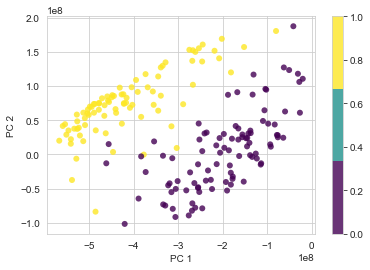

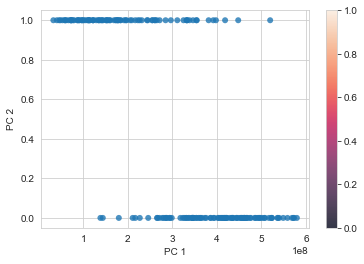

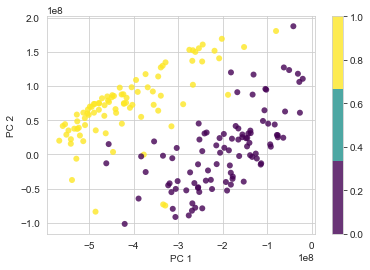

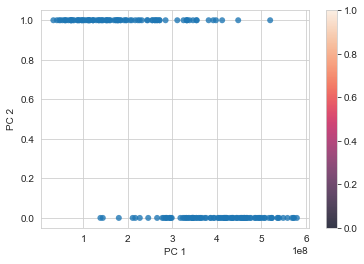

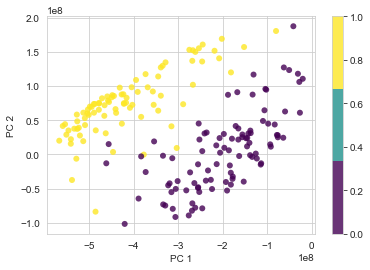

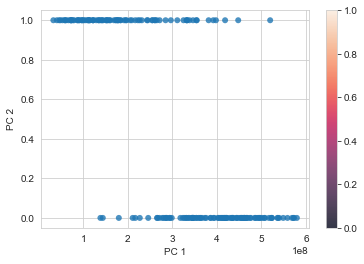

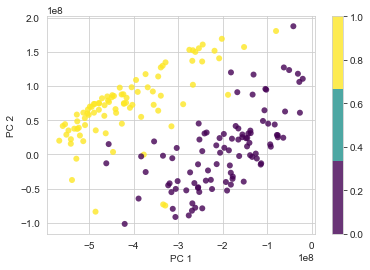

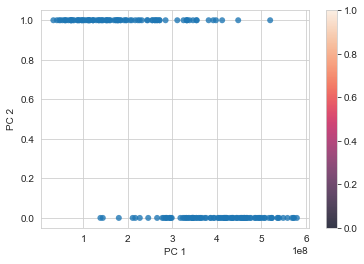

In [851]:
show_PCA(x_test, y_pred)
show_PCA(x_test, y_test)

#### KNN:

In [852]:
param_grid = {'n_neighbors':list(range(1, 11)),
              'weights':['uniform', 'distance'],
              'metric':['euclidean', 'manhattan', 'chebyshev', 'cosine']
              }
clf_knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid, cv=3, scoring='f1')

In [823]:
best_clf_knn = clf_knn.fit(x_train, y_train)

In [824]:
best_clf_knn.best_estimator_

KNeighborsClassifier(metric='manhattan', n_neighbors=8)

In [825]:
print(best_clf_knn.best_score_)

y_pred = best_clf_knn.predict(x_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1:', f1_score(y_test, y_pred))

0.9554936556450196
Accuracy: 0.9675675675675676
F1: 0.9655172413793104


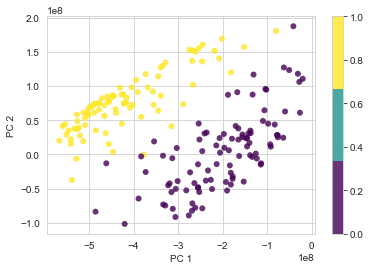

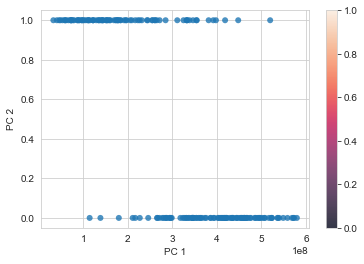

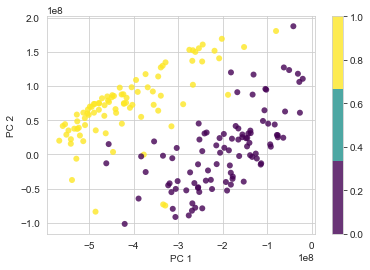

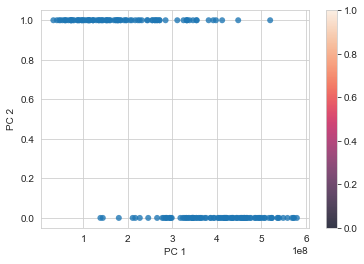

In [826]:
show_PCA(x_test, y_pred)
show_PCA(x_test, y_test)

#### Naive Bayes:

In [827]:
gauss_nb = GaussianNB()
gauss_nb_model = GridSearchCV(estimator=gauss_nb, param_grid={}, cv=3)
gauss_nb_model.fit(x_train, y_train)

y_pred = gauss_nb_model.predict(x_test)

In [828]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1:', f1_score(y_test, y_pred))

Accuracy: 0.9621621621621622
F1: 0.96


In [829]:
pca = PCA(2)

pca_data = pd.DataFrame(pca.fit_transform(data))
param_grid = [{
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['newton-cg', 'sag', 'saga', 'lbfgs', 'liblinear'],
    'max_iter': [100, 1000, 1500],
    'random_state': [42]
}]
x_train, x_test, y_train, y_test = train_test_split(pca_data, target, test_size=0.2, random_state=42)
clf_log_reg = GridSearchCV(estimator=log_reg_model, param_grid=param_grid, cv=3, scoring='f1')
best_clf_log_reg = clf_log_reg.fit(x_train, y_train)
best_clf_log_reg.best_estimator_

LogisticRegression(penalty='l1', random_state=42, solver='liblinear')

In [830]:
y_pred = best_clf_log_reg.predict(x_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1:', f1_score(y_test, y_pred))

Accuracy: 0.9351351351351351
F1: 0.9325842696629215


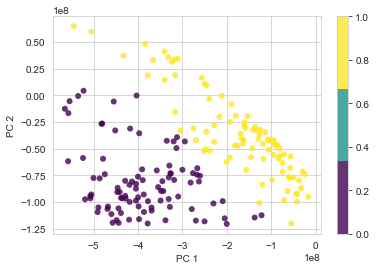

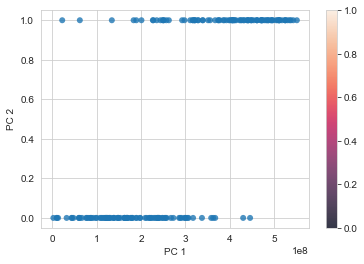

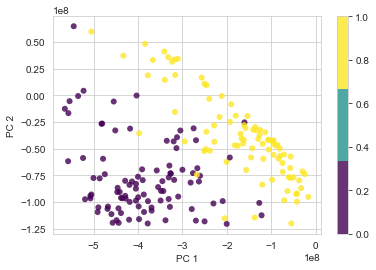

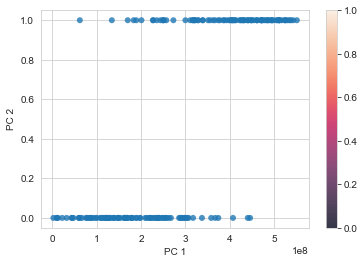

In [831]:
show_PCA(x_test, y_pred)
show_PCA(x_test, y_test)